In [329]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [330]:
df = pd.read_csv('source/FReDA4.csv')

In [331]:
traits = [
    "Relationship Length",
    "Married",
    "Cohabitation",
    "Kids"
]

# traits.sort()

In [332]:
df_couple = df.melt(
    id_vars=["Group2", "Wish for Touch"],
    value_vars=traits,
    var_name="Trait",
    value_name="Score"
)

df_couple_summ = (
    df_couple
    .groupby(["Trait", "Group2"], observed=True)["Score"]
    .agg(['mean', 'std', 'median'])
    .reset_index()
)

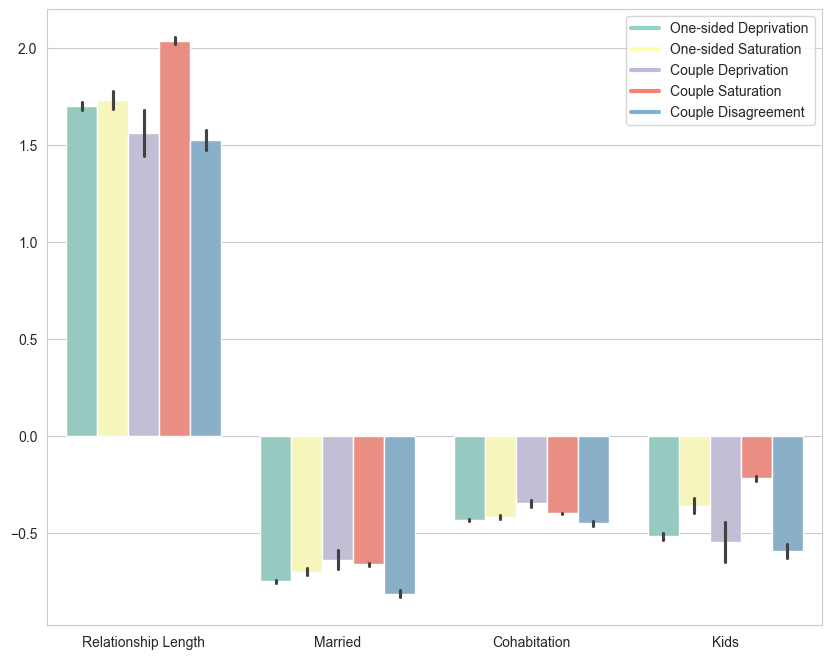

In [333]:
means = df_couple.groupby(["Trait", "Group2"], as_index=False)["Score"].mean()

baseline = means.loc[means["Group2"] == "Couple Agreement", ["Trait", "Score"]]
baseline = baseline.rename(columns={"Score": "Baseline"})

mean_baseline = baseline["Baseline"].mean()

df_couple["DeviationFromMean"] = df_couple["Score"] - mean_baseline
df_plot = df_couple[df_couple["Group2"] != "Couple Deprivation"]
group_order = sorted(df_plot["Group2"].unique())

colors = sns.color_palette('Set3', 5)
plt.figure(figsize=(10, 8))

sns.barplot(
    data=df_plot,
    x="Trait",
    y="DeviationFromMean",
    hue="Group2",
    hue_order=group_order,  # alphabetical
    errorbar="se",
    palette=colors  # make sure this is a list of 8 colors or a dict mapping
)

group_labels = [
    'One-sided Deprivation', 'One-sided Saturation  ', 'Couple Deprivation ',
    'Couple Saturation   ', 'Couple Disagreement',

]
handles = [
    plt.Line2D([0], [0], color=colors[i], lw=3, label=group_labels[i])
    for i in range(len(group_labels))
]
plt.legend(handles=handles, labels=group_labels)
plt.ylabel("")
plt.xlabel("")
plt.savefig('output/img_bg/alles/relationship.png', dpi=600, transparent=False, bbox_inches='tight')

In [334]:
traits = [
    # "Age",
    # "Sex",
    # "Work Status",
    # "Neuroticism",
    # "Extraversion",
    # "Openness",
    # "Agreeableness",
    # "Conscientiousness",
    # "Depressiveness",
    # "Loneliness",
    # "Self-esteem",
    # "Life Satisfaction",
    # "Health",
    "Communication Quality",
    "Relationship Satisfaction",
    "Conflict Management",
]

In [335]:
df_couple = df.melt(
    id_vars=["Group1", "Wish for Touch"],
    value_vars=traits,
    var_name="Trait",
    value_name="Score"
)

df_couple_summ = (
    df_couple
    .groupby(["Trait", "Group1"], observed=True)["Score"]
    .agg(['mean', 'std', 'median'])
    .reset_index()
)

In [336]:
group_labels = [
    'I am okay and my partner is okay', 'I am deprived and my partner is okay',
    'I am deprived and my partner is deprived', 'I am deprived and my partner is saturated',
    'I am saturated and my partner is okay', 'I am saturated and my partner is saturated',
    'I am okay and my partner is deprived', 'I am okay and my partner is saturated'
]

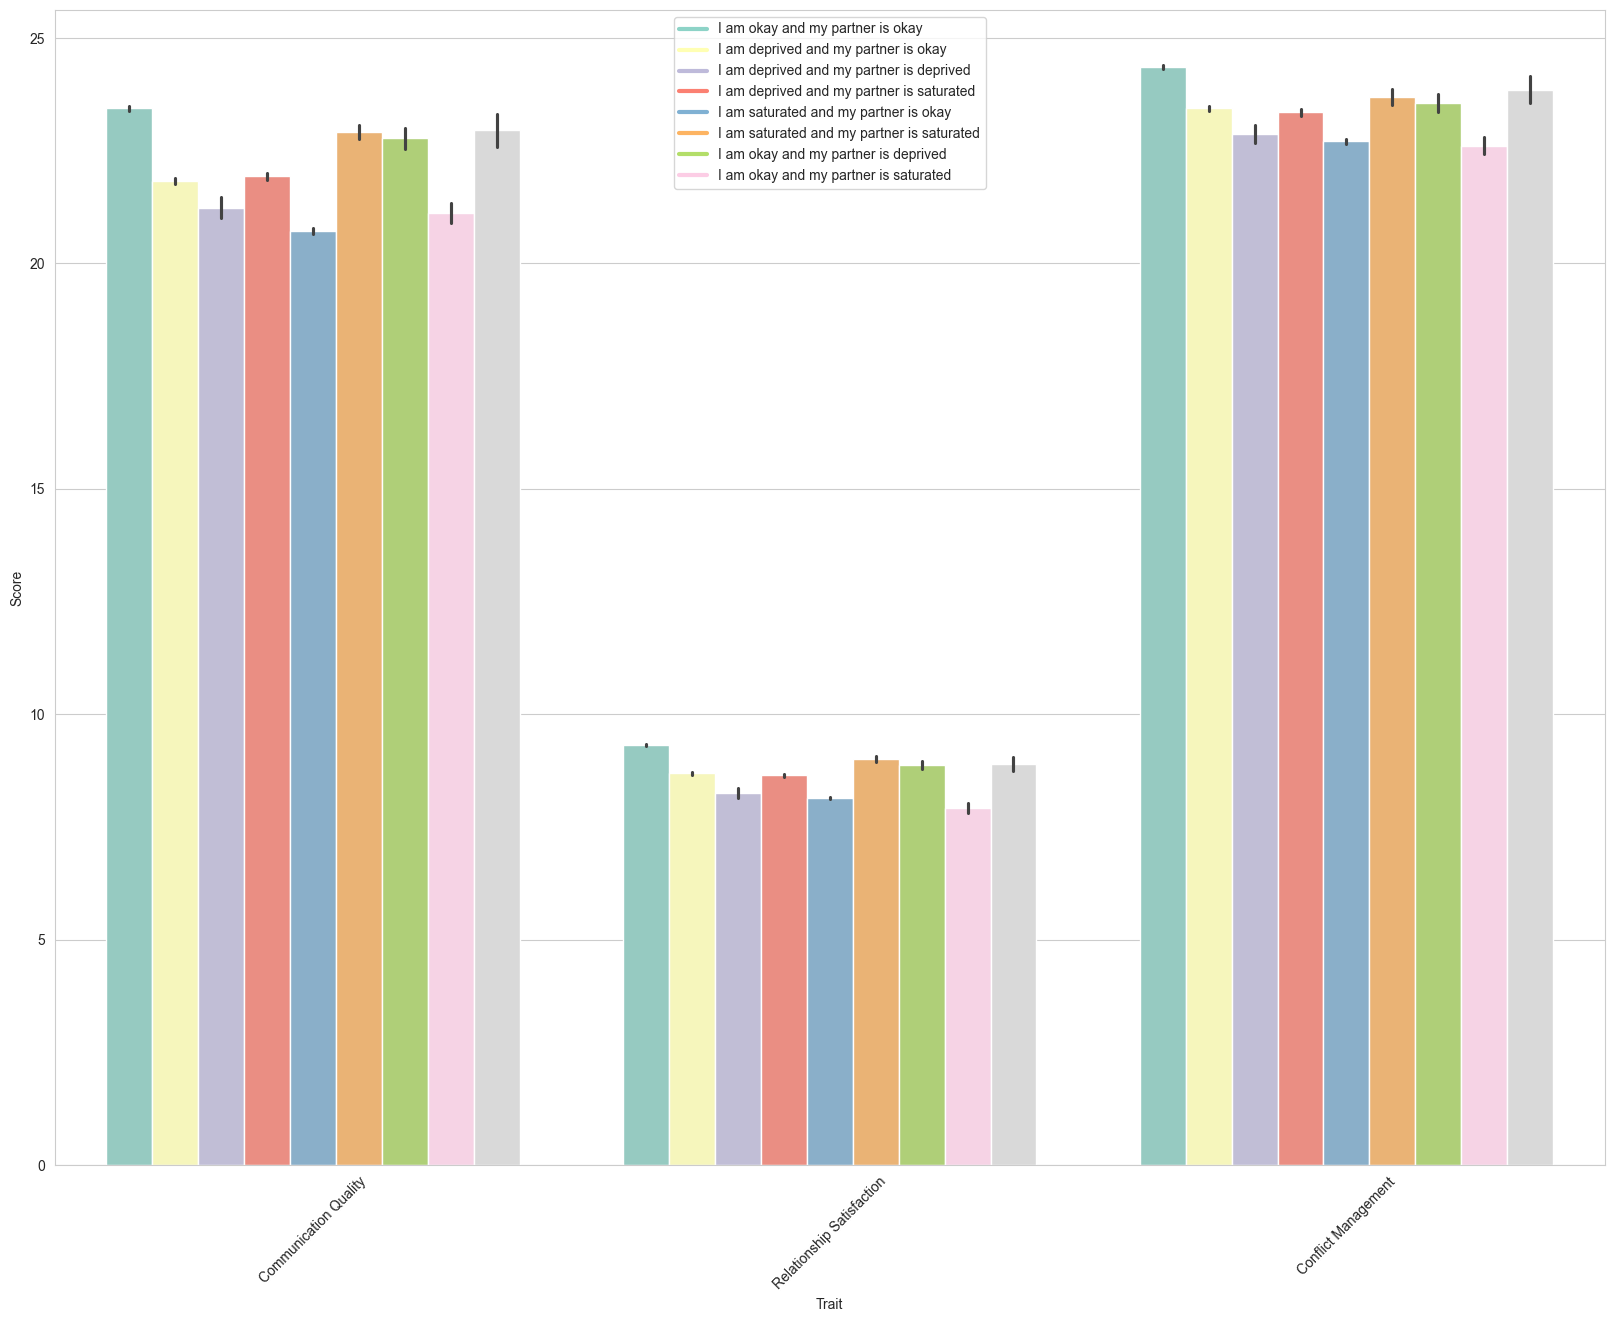

In [337]:
from statannotations.Annotator import Annotator
from scipy.stats import rankdata

# pairs = [
#     (("Loneliness", "SubGroup1"), ("Loneliness", "SubGroup2")),
#     (("Loneliness", "SubGroup1"), ("Loneliness", "SubGroup3")),
#     (("Loneliness", "SubGroup1"), ("Loneliness", "SubGroup4")),
#     (("Loneliness", "SubGroup1"), ("Loneliness", "SubGroup5")),
#     (("Loneliness", "SubGroup1"), ("Loneliness", "SubGroup6")),
#     (("Loneliness", "SubGroup1"), ("Loneliness", "SubGroup7")),
#     (("Loneliness", "SubGroup1"), ("Loneliness", "SubGroup8")),
# ]

plt.figure(figsize=(20, 15))
colors = sns.color_palette('Set3', 9)
ax = sns.barplot(data=df_couple, x="Trait", y="Score",
                 hue="Group1", palette=colors, errorbar="se",
                 )

# annot = Annotator(
#     ax, pairs, data=df_couple, x="Trait",
#     y="Score", hue="Group1",
# )
# annot.configure(test='Mann-Whitney', verbose=2,
#                 pvalue_thresholds=[[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']])
# annot.apply_test()
# annot.annotate()

plt.xticks(rotation=45)
handles = [
    plt.Line2D([0], [0], color=colors[i], lw=3, label=group_labels[i])
    for i in range(len(group_labels))
]
plt.legend(handles=handles, labels=group_labels)
plt.savefig('output/img_bg/alles/communication.png', dpi=600, transparent=False, bbox_inches='tight')

In [338]:
results = []
for trait in traits:
    pairs = [
        ((trait, "SubGroup1"), (trait, "SubGroup2")),
        ((trait, "SubGroup1"), (trait, "SubGroup3")),
        ((trait, "SubGroup1"), (trait, "SubGroup4")),
        ((trait, "SubGroup1"), (trait, "SubGroup5")),
        ((trait, "SubGroup1"), (trait, "SubGroup6")),
        ((trait, "SubGroup1"), (trait, "SubGroup7")),
        ((trait, "SubGroup1"), (trait, "SubGroup8")),
    ]
    for (trait1, group1), (trait2, group2) in pairs:
        scores1 = df_couple[(df_couple["Trait"] == trait1) &
                            (df_couple["Group1"] == group1)]["Score"].dropna()
        scores2 = df_couple[(df_couple["Trait"] == trait2) &
                            (df_couple["Group1"] == group2)]["Score"].dropna()

        u_stat, p_val = mannwhitneyu(scores1, scores2, alternative='two-sided')

        n1, n2 = len(scores1), len(scores2)
        mean_u = n1 * n2 / 2
        std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
        z = (u_stat - mean_u) / std_u
        r = z / np.sqrt(n1 + n2)

        results.append({
            "Trait": trait1,
            "Control": group1,
            "Experiment": group2,
            "U": u_stat,
            "p-value": p_val,
            "r": r
        })

    df_couple_results = pd.DataFrame(results)

In [339]:
# 1. Dummy code data in terms of significance (ns= 0.5, *=1, **=1.5, and ***= 2.0)
def val_to_category(val):
    if val < 0.001:
        return 4
    elif val < 0.01:
        return 3
    elif val < 0.5:
        return 2
    else:
        return 1


def sig_to_category(val):
    if val < 0.001:
        return '***'
    elif val < 0.01:
        return '**'
    elif val < 0.5:
        return '*'
    else:
        return 'ns'


# df_couple_results['significance'] = df_couple_results['p-value'].apply(val_to_category)
df_couple_results['summary'] = df_couple_results['p-value'].apply(sig_to_category)

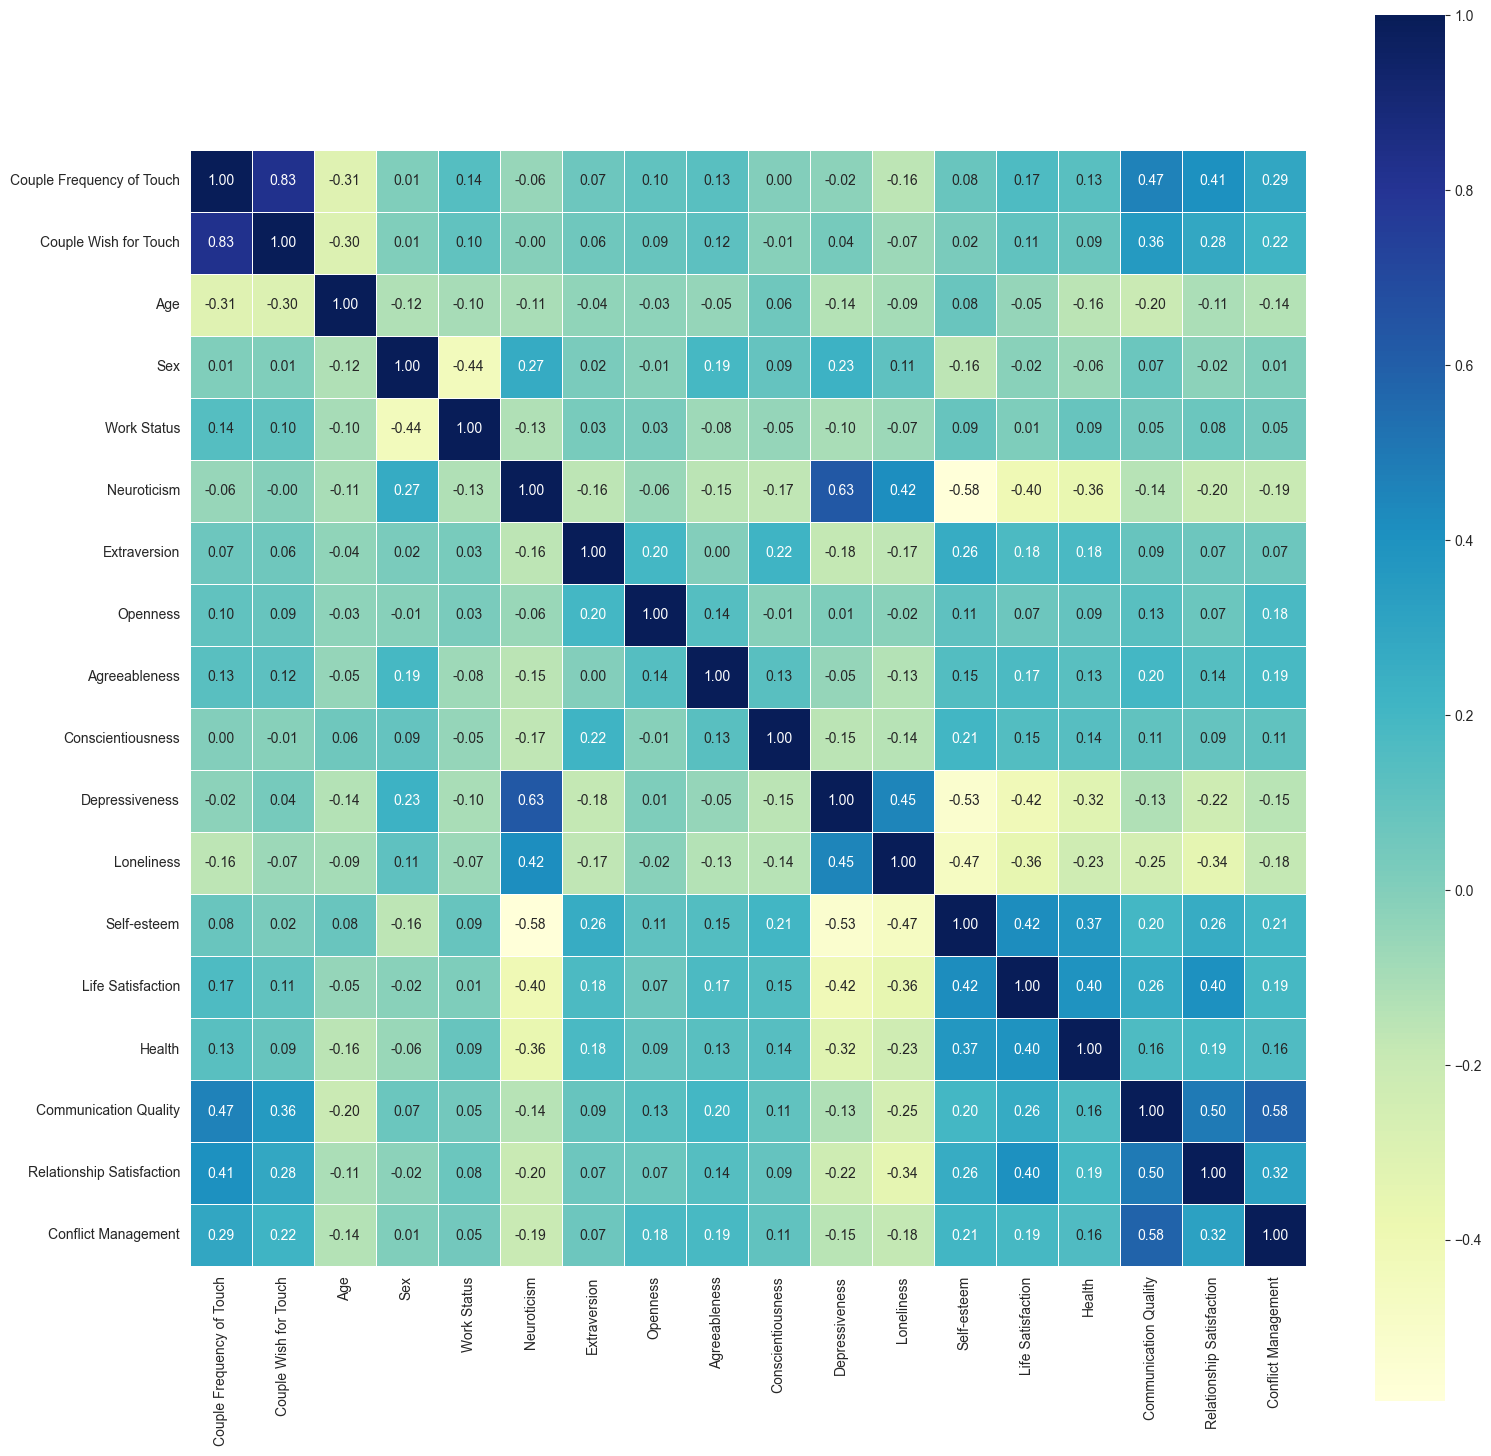

In [340]:
traits = [
    "Age",
    "Sex",
    "Work Status",
    "Neuroticism",
    "Extraversion",
    "Openness",
    "Agreeableness",
    "Conscientiousness",
    "Depressiveness",
    "Loneliness",
    "Self-esteem",
    "Life Satisfaction",
    "Health",
    "Communication Quality",
    "Relationship Satisfaction",
    "Conflict Management",
]
touch = ["Couple Frequency of Touch", "Couple Wish for Touch"]
correlation = df[touch + traits].corr(method='spearman')

num_vars = len(correlation.columns)
square_size = 1  # in inches, per cell

fig_width = num_vars * square_size
fig_height = num_vars * square_size

plt.figure(figsize=(fig_width, fig_height))

sns.heatmap(correlation, cmap='YlGnBu',
            fmt='.2f',
            linewidths=0.5,
            # vmax=0.7,
            # vmin=-0.7,
            annot_kws={"size": 10},
            annot=True,
            square=True
            )

plt.grid(False)
# plt.savefig('output/img_bg/alles/corr.png', dpi=600, transparent=False, bbox_inches='tight')

C:\Users\Edo\AppData\Local\Temp\ipykernel_21904\3832145543.py:14: UserWarning: The palette list has more values (9) than needed (8), which may not be intended.
  sns.barplot(


Text(0.5, 0, '')

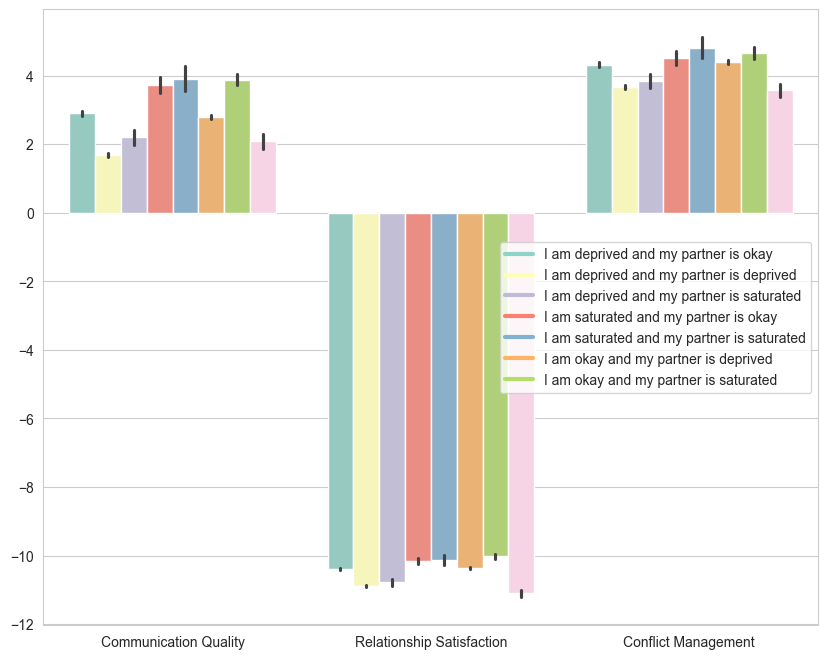

In [341]:
means = df_couple.groupby(["Trait", "Group1"], as_index=False)["Score"].mean()

baseline = means.loc[means["Group1"] == "SubGroup1", ["Trait", "Score"]]
baseline = baseline.rename(columns={"Score": "Baseline"})

mean_baseline = baseline["Baseline"].mean()

df_couple["DeviationFromMean"] = df_couple["Score"] - mean_baseline
df_plot = df_couple[df_couple["Group1"] != "SubGroup1"]
group_order = sorted(df_plot["Group1"].unique())

plt.figure(figsize=(10, 8))

sns.barplot(
    data=df_plot,
    x="Trait",
    y="DeviationFromMean",
    hue="Group1",
    hue_order=group_order,  # alphabetical
    errorbar="se",
    palette=colors  # make sure this is a list of 8 colors or a dict mapping
)
group_labels = [
    'I am deprived and my partner is okay',
    'I am deprived and my partner is deprived', 'I am deprived and my partner is saturated',
    'I am saturated and my partner is okay', 'I am saturated and my partner is saturated',
    'I am okay and my partner is deprived', 'I am okay and my partner is saturated'
]
handles = [
    plt.Line2D([0], [0], color=colors[i], lw=3, label=group_labels[i])
    for i in range(len(group_labels))
]
plt.legend(handles=handles, labels=group_labels)
plt.ylabel("")
plt.xlabel("")
# plt.savefig('output/img_bg/alles/relationship.png', dpi=600, transparent=False, bbox_inches='tight')